# Rotations

**Convention: A positive rotation, about the z-axis, in a Right Handed Coordinate frame is defined as a rotation where the x-axis moves towards the y-axis**

Corrolarys

1. A positive rotation, is CCW when you are looking from the +ve zed axis, down onto the Z=0 plane.

2. A positive rotation, is CW when you are looking from the -ve zed axis, up onto the Z=0 plane.

3. A positive rotation, causes the X-axis to rotate towards the Y-axis

**Convention: X: North; Y: East, Z: Down a.k.a. NED**
This is in contrast to the ENU frame.


Things that invert polarity that one needs to watch out for:

A.  Coordinate Frame: If you switch between NED and ENU, the effect of the same rotation matrix on a vector, will push it in the opposite direction, when you look at the vector in the cardinal frame.

B. The sign of the rotation angle (+ve, vs -ve angle). 

C. Choice of similarity transform definition $R Z R^T$ vs $R^T Z R$ 

- We use $R Z R^T$ whic is appropriate for the MT Equation formulation $E = ZH$

D. Definition of Rotation Matrix

In [1]:
import numpy as np
# from scipy.spatial.transform import Rotation

In [2]:
theta = np.deg2rad(90)

### NED: X:North, Y: East, Z: Down

### ENU: X:East, Y: North, Z: Up

Here are the cardinal points for the two conventions:

In [3]:
reference_points = {}
reference_points["NED"] = {
    "north": np.array([1, 0]), 
    "east" : np.array([0, 1]),
    "south": np.array([-1, 0]), 
    "west" : np.array([0, -1]),
}
reference_points["ENU"] = {
    "north": np.array([0, 1]), 
    "east" : np.array([1, 0]),
    "south": np.array([0, -1]), 
    "west" : np.array([-1, 0]),
}


**This R takes North and rotates it towards to West in an NED coordinate system**
This R matrix, is the rotation matrix that satisfies for +ve theta the conventiosn C1-C3

Here we will define our rotation matrix.  Careful, if this isn't correct things will go backwards.

In [14]:
def rotation_matrix(
    theta: float,
    conventional: bool = True
) -> np.ndarray:
    """
    theta: angle in radians
    """
    R = np.asarray(
        [
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)],
        ]
    )
    if conventional is False:
        R = R.T  # this was the problem in issue 57 mtpy

    # uncommnet below to hide 1e-17 floating point stuffs when looking at tutorial
    # for i in range(2):
    #     for j in range(2):
    #         if np.abs(R[i,j]) < 1e-15:
    #             #print(i,j)
    #             R[i,j] = 0

    return R
    


In [15]:
R = rotation_matrix(theta, conventional=False)
R

array([[ 6.123234e-17,  1.000000e+00],
       [-1.000000e+00,  6.123234e-17]])

In [16]:
# R.T == R^(-1)
# Like all rotation matrices, R.T is the inverse of R
R.T @ R

array([[1., 0.],
       [0., 1.]])

Lets see the effect of this rotation matrix:

In [17]:
coordinate_frame = "NED"
initial_direction = "north"
result = R @ reference_points[coordinate_frame][initial_direction]

for direction,vector in reference_points[coordinate_frame].items():
    difference = np.abs(result-vector)
    #print(direction, difference)
    if np.isclose(difference,0, atol=1e-10).all():
        print(f"{initial_direction} in {coordinate_frame} points {direction} after multiply")# by {R}")

north in NED points west after multiply


Whoops, look at the message, X-North, didnt rotate toward Y, as it should .. it rotated away from Y

In [18]:
R = rotation_matrix(theta, conventional=True)

#### Try again:


In [19]:
coordinate_frame = "NED"
initial_direction = "north"
result = R @ reference_points[coordinate_frame][initial_direction]

for direction,vector in reference_points[coordinate_frame].items():
    difference = np.abs(result-vector)
    #print(direction, difference)
    if np.isclose(difference,0, atol=1e-10).all():
        print(f"{initial_direction} in {coordinate_frame} points {direction} after multiply")# by {R}")

north in NED points east after multiply


Yup, thats right.

### ENU: X:East, Y: North, Z: Up

In [20]:
coordinate_frame = "ENU"
initial_direction = "north"
result = R @ reference_points[coordinate_frame][initial_direction]

for direction,vector in reference_points[coordinate_frame].items():
    difference = np.abs(result-vector)
    #print(direction, difference)
    if np.isclose(difference,0, atol=1e-10).all():
        print(f"{initial_direction} in {coordinate_frame} points {direction} after multiply")# by {R}")


north in ENU points west after multiply


So the same rotation matrix rotates the vector in opposite directions depending on the coordinate system.

In [21]:
R = rotation_matrix(np.deg2rad(30))

In [22]:
Z_temp = np.asarray(
    [
        [1, 2],
        [3, 4],
    ]
) 

In [23]:
R @ Z_temp @ R.T

array([[-0.41506351, -0.54903811],
       [ 0.45096189,  5.41506351]])

In [24]:
R.T @ Z_temp @ R

array([[3.91506351, 2.04903811],
       [3.04903811, 1.08493649]])

**See above: RT Z R does not equal R Z RT in general**
(but it does for 90degree angles)

# TODO Clean up math here:
#### Justification for selection of R Z RT

$E_x = Zxx Hx + Zxy Hy$

Assuming Hx, Hy are orthogonal, say Hx was 30 degrees was off north, pointing NNE and Hy was 30 degrees off East, pointing ESE.

Then to Get H projected onto North and East (in our NED system) we would want to rotate by -30 degrees.

...

To fix the electric fields, (if everything was labelled correct .. careful here, we would do the same)


In [26]:
"""
Z = [
    Zxx, Zxy
    Zyx, Zyy
    ]

In the beginninig X, Y are just the axes of data acquistion, they are not cardinal driections yet
Let Z_card denote the impedance tensor in cardinal frame.

E = Z H
Ex = ZxxHx + ZxyHy
Ey = ZyxHx + ZyyHy

RE = Z_card RH  # mult both sides by RT
RT RE = RT Z_card RH  The LHS becomes E
E = RT Z_card RH  The LHS becomes E
But then that equals ZH by definition ...  E = Z H, substitute ZH for E
ZH = RT Z_card RH Now notice that AB = CB IFF A==C (remocve the H)
Z = RT Z_card R ... multiply by R on the left
RZ = Z_card R ... multiply by RT on the right
R Z RT = Z_card


 E = Z H




En = ZnnHn + ZneHe
Ee = ZenHn + ZeeHe
"""

'\nZ = [\n    Zxx, Zxy\n    Zyx, Zyy\n    ]\n\nIn the beginninig X, Y are just the axes of data acquistion, they are not cardinal driections yet\nLet Z_card denote the impedance tensor in cardinal frame.\n\nE = Z H\nEx = ZxxHx + ZxyHy\nEy = ZyxHx + ZyyHy\n\nRE = Z_card RH  # mult both sides by RT\nRT RE = RT Z_card RH  The LHS becomes E\nE = RT Z_card RH  The LHS becomes E\nBut then that equals ZH by definition ...  E = Z H, substitute ZH for E\nZH = RT Z_card RH Now notice that AB = CB IFF A==C (remocve the H)\nZ = RT Z_card R ... multiply by R on the left\nRZ = Z_card R ... multiply by RT on the right\nR Z RT = Z_card\n\n\n E = Z H\n\n\n\n\nEn = ZnnHn + ZneHe\nEe = ZenHn + ZeeHe\n'

In [27]:

Z_temp = np.asarray(
    [
        [0.3, complex(2,1)],
        [3, 4],
    ]
) 
Z_temp

array([[0.3+0.j, 2. +1.j],
       [3. +0.j, 4. +0.j]])

In [28]:
R@Z_temp@R.T

array([[-0.94006351-0.4330127j, -0.852147  +0.75j     ],
       [ 0.147853  -0.25j     ,  5.24006351+0.4330127j]])

In [29]:
# x1, x2: S1 S2
# x3, x4: D1 D2
# def simpson_strike(Z, alpha):
#     S1 = Z[0,0] + Z[1, 1]
#     S2 = Z[0,1] + Z[1, 0]
#     D1 = Z[0,0] - Z[1, 1]
#     S2 = Z[0,1] - Z[1, 0]
#     S2_prime = (S2 * np.cos(alpha)**2) - (D1 * np.sin(alpha)**2)
#     D1_prime = (D1* np.cos(alpha)**2) + (S2 * np.sin(alpha)**2)
    
#     numerator = 2*np.real()
#     fouralpha = np.arctan2()

In [30]:
import copy

In [33]:
square_diag = np.zeros(360)
for i in range(360):
    R = rotation_matrix(np.deg2rad(i))
    rotated = R@Z_temp@R.T
    square_diag[i] = np.abs(rotated[0,0])**2 + np.abs(rotated[1,1])**2

import matplotlib.pyplot as plt
initial_square_diag = copy.deepcopy(square_diag)
#plt.plot(square_diag)
    

In [34]:
R30  =rotation_matrix(np.deg2rad(10))

In [35]:
Z30 = R30@Z_temp@R30.T

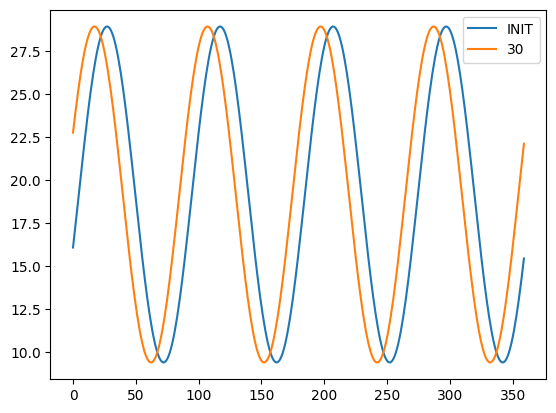

In [37]:
square_diag = np.zeros(360)
for i in range(360):
    R = rotation_matrix(np.deg2rad(i))
    rotated = R@Z30@R.T
    square_diag[i] = np.abs(rotated[0,0])**2 + np.abs(rotated[1,1])**2
square_diag_30 = copy.deepcopy(square_diag)
import matplotlib.pyplot as plt
plt.plot(initial_square_diag, label="INIT")
plt.plot(square_diag_30, label="30")
plt.legend()

In [137]:
R30 @ np.array([1, 0]).T

array([ 0.98480775, -0.17364818])